In [1]:
from numpy.fft import fft, ifft, hfft
from scipy.signal import lfilter
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from IPython.display import Audio
from scipy import signal

figsize=(10,5)

In [2]:
fs = 44100

# Filters

In [39]:
def notch(z, wc, G=3, Q=0.99):
    return G * (1 - 2 * np.cos(wc)*np.power(z, -1) + np.power(z, -2)) \
    / (1 - 2 * Q * np.cos(wc) * np.power(z, -1) + Q**2 * np.power(z, -2) ) 

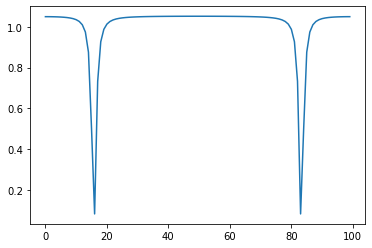

In [33]:
# Frequency response
z = np.exp ( 1j * 2 * np.pi * np.linspace(0, fs, 100) / fs )
plt.plot( np.real( notch(z, 1, .95, 1) ))

In [57]:
def shelf(z, wc, G=2, band="low"):
    invert_G = 1
    if band=="high":
        invert_G = G
        G = 1/G
        
    return (invert_G * (G * np.tan(wc/2) + np.sqrt(G) + (G* np.tan(wc/2)-np.sqrt(G))*np.power(z, -1))) \
    / ( (np.tan(wc/2) + np.sqrt(G) + (np.tan(wc/2)-np.sqrt(G))*np.power(z, -1)) )

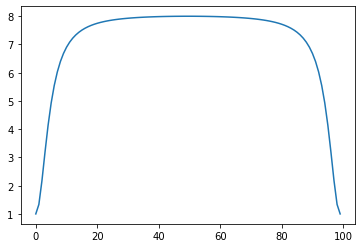

In [67]:
# Frequency response
z = np.exp ( 1j * 2 * np.pi * np.linspace(0, fs, 100) / fs )
plt.plot( np.real( shelf(z, 0.1, 8, "high") ))

In [51]:
# Actual filter function
def eq_filter(x, filter_func, fc, G, *args):
    """Apply a filter on signal x

    Parameters:
    x : The input signal in time domain, sampled at freq fs.
    filter_func : a python function representing the desired filter to apply
    fc : the filter's central frequency in hertz
    G : the gain of the filter
    *args : any additional param dependent on the filter

    Returns:
    numpy_array : the ouput signal in time domain after application of the notch filter

    """
    w = np.linspace(0, 2*np.pi, x.size) # Omega from 0 to 2*pi
    z = np.exp ( 1j * w ) # Convert z-transform to Fourier
    
    X = fft(x) # Convert to frequency domain
    X_filter = X * filter_func(z, fc*2*np.pi/fs, G, *args) # Apply the filter in frequency domain
    x_filter = np.real( ifft(X_filter) ) # Convert to time domain
    x_filter /= np.max(np.abs(x_filter) ) # Normalize
    
    return x_filter

# Guitar sample

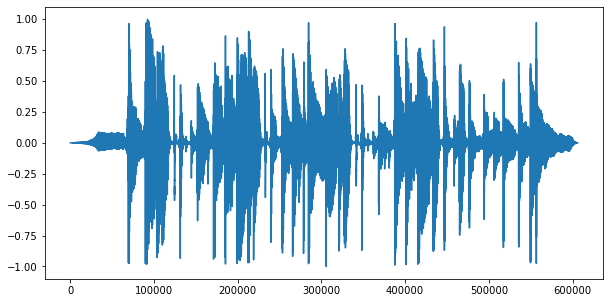

In [34]:
fs, data = wavfile.read('samples/guitar.wav')
guitar_sample = np.array(data, dtype=np.float32)
guitar_sample /= np.max(np.abs(guitar_sample) )
plt.figure(figsize=figsize)
plt.plot(guitar_sample)
Audio("samples/guitar.wav", autoplay=False)

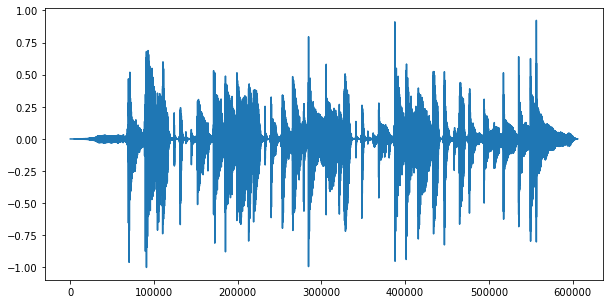

In [68]:
guitar_EQ = eq_filter(guitar_sample, shelf, 100, 8, "high")

plt.figure(figsize=figsize)
plt.plot(guitar_EQ)
wavfile.write('samples/guitar_EQ.wav', fs, guitar_EQ)
Audio("samples/guitar_EQ.wav", autoplay=False)